<a href="https://colab.research.google.com/github/ebaaamostafa/Brain-Tumor-Detection/blob/main/Brain_Tumor_Detection_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This notebook explores a medical dataset for brain tumor detection.

## Author:
> Ebaa Mostafa Aboelnaga
> ebaaaboelnaga@gmail.com

# import dataset from kaggle

In [ ]:
import kagglehub
masoudnickparvar_brain_tumor_mri_dataset_path = kagglehub.dataset_download('masoudnickparvar/brain-tumor-mri-dataset')

print('Data source import complete.')


Data source import complete.


# import needed libraries

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import random

# Loading dataset

### hyperparameters

In [ ]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42

**for** reproducability:

In [ ]:
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

### paths to datasets

In [ ]:
train_dir = "/kaggle/input/brain-tumor-mri-dataset/Training"
test_dir = "/kaggle/input/brain-tumor-mri-dataset/Testing"

train_ds = image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

val_ds = image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

test_ds = image_dataset_from_directory(
    test_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

class_names = train_ds.class_names
print("classes:", class_names)

Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 5712 files belonging to 4 classes.
Using 1142 files for validation.
Found 1311 files belonging to 4 classes.
classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


## visualize data

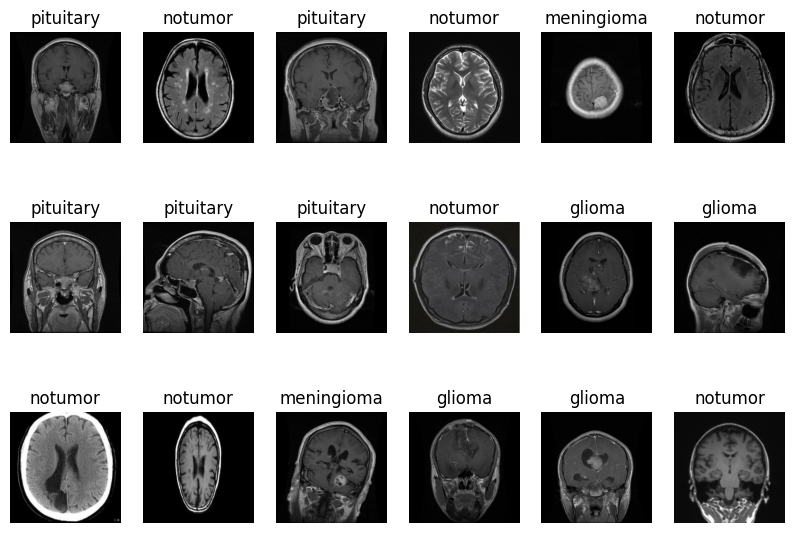

In [ ]:
plt.figure(figsize=(10, 7))
for images, labels in train_ds.take(1):
    for i in range(18):
        ax = plt.subplot(3, 6, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        label_index = tf.argmax(labels[i]).numpy()
        plt.title(class_names[label_index])
        plt.axis("off")

## dataset size

In [ ]:
def count_images_in_folder(folder_path):
    class_counts = {}
    total_images = 0
    for class_name in os.listdir(folder_path):
        class_dir = os.path.join(folder_path, class_name)
        if os.path.isdir(class_dir):
            num_images = len([
                f for f in os.listdir(class_dir)
                if f.lower().endswith(('.png', '.jpg', '.jpeg'))
            ])
            class_counts[class_name] = num_images
            total_images += num_images
    return class_counts, total_images

train_counts, train_total = count_images_in_folder(train_dir)
test_counts, test_total = count_images_in_folder(test_dir)

print("Train Class Counts:", train_counts)
print("Train Total:", train_total)
print("Test Class Counts:", test_counts)
print("Test Total:", test_total)
print("Overall Total:", train_total + test_total)

Train Class Counts: {'pituitary': 1457, 'notumor': 1595, 'meningioma': 1339, 'glioma': 1321}
Train Total: 5712
Test Class Counts: {'pituitary': 300, 'notumor': 405, 'meningioma': 306, 'glioma': 300}
Test Total: 1311
Overall Total: 7023


### => data is fairly balanced, no biases exist.

### even tho, data augmentation is recommended especially for a medical sensitive info
> the last thing we might ever want here is overfitting!

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomTranslation(0.1, 0.1),
])

## prefetch data to improve performance, preprocessing data while model is executing.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

# model
**EfficientNetB0** model is pre-trained on the ImageNet dataset

In [ ]:
base_model = EfficientNetB0(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

In [ ]:
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.2),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')
])

- The final **softmax** layer outputs a probability distribution over the 4 tumor classes.




In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,214,055 (16.08 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

## callback

In [ ]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "best_model.keras",
    save_best_only=True,
    monitor="val_accuracy"
)

earlystop_cb = tf.keras.callbacks.EarlyStopping(
    patience=5,
    restore_best_weights=True
)


- **ModelCheckpoint** saves the best version of your model during training.
- **EarlyStopping** stops training if the model doesn’t improve for 5 consecutive epochs to avoid overfitting.

# train model

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[checkpoint_cb, earlystop_cb]
)

Epoch 1/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 57s 232ms/step - accuracy: 0.7333 - loss: 0.6466 - val_accuracy: 0.8940 - val_loss: 0.2785
Epoch 2/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 48s 73ms/step - accuracy: 0.8813 - loss: 0.3069 - val_accuracy: 0.9107 - val_loss: 0.2377
Epoch 3/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 10s 67ms/step - accuracy: 0.9053 - loss: 0.2501 - val_accuracy: 0.9212 - val_loss: 0.2113
Epoch 4/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 12s 76ms/step - accuracy: 0.9253 - loss: 0.2084 - val_accuracy: 0.9308 - val_loss: 0.1930
Epoch 5/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 21s 79ms/step - accuracy: 0.9263 - loss: 0.1971 - val_accuracy: 0.9387 - val_loss: 0.1840
Epoch 6/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 19s 69ms/step - accuracy: 0.9276 - loss: 0.1876 - val_accuracy: 0.9335 - val_loss: 0.1801
Epoch 7/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 9s 60ms/step - accuracy: 0.9374 - loss: 0.1549 - val_accuracy: 0.9387 - val_loss: 0.1741
Epoch 8/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step - accuracy: 0.9415 - loss: 0.1481 - 

Training the model for 20 epochs on the training dataset and validating.

call backs help manage early stopping and saving the best model reached.

# Evaluation

In [ ]:
model.evaluate(test_ds)

41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 0.9448 - loss: 0.1452


[0.14122259616851807, 0.952707827091217]

### Testing model performance on test data

- `41` total batches
- time taken to process each batch: `10s 248ms`
### final loss and accuracy values after fully testing the model:
- loss ≃ `0.14`
- accuracy ≃ `95.2%`

# train X validation accuracies:

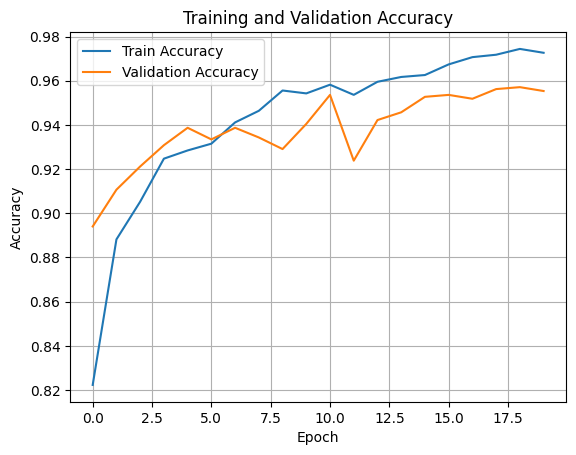

In [ ]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

This graph shows how training and validation accuracy evolved over time, helps in identifying overfitting and underfitting if existed.

# confusion matrix

In [ ]:
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(tf.argmax(labels, axis=1).numpy())
    y_pred.extend(tf.argmax(preds, axis=1).numpy())

cm = confusion_matrix(y_true, y_pred)


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━

visualize matrix

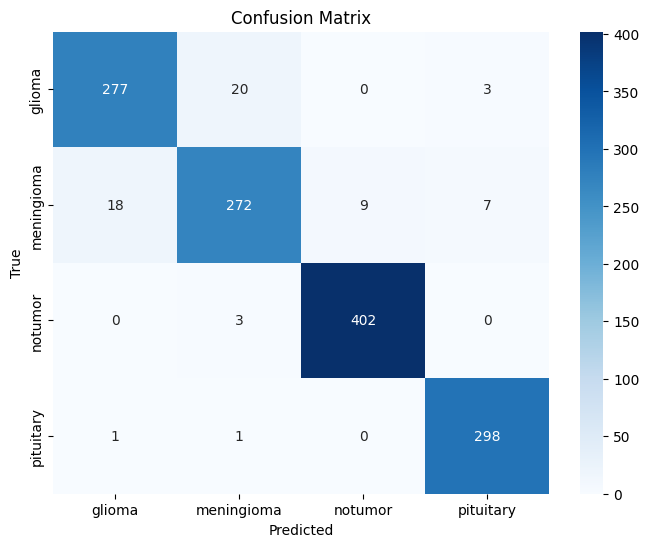

              precision    recall  f1-score   support

      glioma       0.94      0.92      0.93       300
  meningioma       0.92      0.89      0.90       306
     notumor       0.98      0.99      0.99       405
   pituitary       0.97      0.99      0.98       300

    accuracy                           0.95      1311
   macro avg       0.95      0.95      0.95      1311
weighted avg       0.95      0.95      0.95      1311



In [ ]:

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_true, y_pred, target_names=class_names))
